# EE511 Final Project

In this file we train the SqueezeNet model as described in the paper found [here](https://arxiv.org/abs/1602.07360).
This implementation uses the CIFAR10 dataset.

## Task 1: Train SqueezeNet

For task 1 we train SqueezeNet for 100 epochs and are able to get a final test accuracy of 81.19%.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.ao.quantization import QuantStub, DeQuantStub
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from collections import OrderedDict

import helper

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device={device}")

Device=cuda


## Implementation

The class in this cell below defines our architecture and defines our forward pass. We insert quantization stub for later Quantization Aware Training. We also define helper functions to save and load the model.

In [2]:
class Fire(nn.Module):
    def __init__(self, inplanes, squeeze_planes, expand_planes):
        super(Fire, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=1)
        self.conv3 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x, epoch=None, inference=False):
        x = self.relu1(self.conv1(x))
        out1 = self.conv2(x)
        out2 = self.conv3(x)
        out = torch.cat([out1, out2], 1)
        out = self.relu2(out)
        return out

class SqueezeNetCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(SqueezeNetCIFAR10, self).__init__()
        # self.upsample = nn.Upsample(size=224, mode='bilinear', align_corners=False)
        self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire2 = Fire(96, 16, 64)
        self.fire3 = Fire(128, 16, 64)
        self.fire4 = Fire(128, 32, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire5 = Fire(256, 32, 128)
        self.fire6 = Fire(256, 48, 192)
        self.fire7 = Fire(384, 48, 192)
        self.fire8 = Fire(384, 64, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire9 = Fire(512, 64, 256)
        self.conv10 = nn.Conv2d(512, num_classes, kernel_size=1)
        # self.avg_pool = nn.AvgPool2d(13)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x, epoch=None, inference=False):
        # x = self.upsample(x)
        x = self.maxpool1(self.conv1(x))

        x = self.fire2(x)
        x = self.fire3(x)
        x = self.fire4(x)
        x = self.maxpool2(x)

        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        x = self.maxpool3(x)

        x = self.fire9(x)
        x = self.conv10(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        return x
    
    def load_model(self, path='squeezenet_fp32.pth',device='cpu'):
        state_dict = torch.load(path,map_location=device)

        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[len('module.'):]
            new_state_dict[k] = v

        self.load_state_dict(new_state_dict)
        self.to(device)
        self.eval()

        print(f"Model loaded from {path}")
        # print(self)

    def save_model(self, path='squeezenet_fp32.pth'):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")


## Load the Dataset

In this cell we define a function to load our dataset.

In [ ]:
train_loader, test_loader = helper.load_dataset(batch_size=128)

## Train the model



In [4]:
def init_weights_he(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.zeros_(m.bias)
        
model_fp32 = SqueezeNetCIFAR10()
model_fp32.apply(init_weights_he)
# model_fp32.load_model('squeezenet_fp32.pth')

SqueezeNetCIFAR10(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (fire2): Fire(
    (conv1): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (fire3): Fire(
    (conv1): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (fire4): Fire(
    (conv1): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (conv3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (maxpool2): M

In [5]:
train, test = True, True
epochs = 100
fp32_metrics = helper.train_model(model=model_fp32,train_loader=train_loader,test_loader=test_loader,train=train,test=test,device=device,epochs=epochs)

Epoch [1/100] 

Train Loss: 2.7372, Train Acc: 10.09% 

Test/Val Loss: 2.3027, Test/Val Acc: 10.00%
Epoch [2/100] 

Train Loss: 2.3027, Train Acc: 9.87% 

Test/Val Loss: 2.3026, Test/Val Acc: 10.00%
Epoch [3/100] 

Train Loss: 2.3027, Train Acc: 9.76% 

Test/Val Loss: 2.3027, Test/Val Acc: 10.00%
Epoch [4/100] 

Train Loss: 2.3028, Train Acc: 9.83% 

Test/Val Loss: 2.3026, Test/Val Acc: 10.00%
Epoch [5/100] 

Train Loss: 2.3027, Train Acc: 9.70% 

Test/Val Loss: 2.3026, Test/Val Acc: 10.00%
Epoch [6/100] 

Train Loss: 2.3028, Train Acc: 9.93% 

Test/Val Loss: 2.3023, Test/Val Acc: 11.16%
Epoch [7/100] 

Train Loss: 2.3028, Train Acc: 9.77% 

Test/Val Loss: 2.3026, Test/Val Acc: 10.00%
Epoch [8/100] 

Train Loss: 2.3018, Train Acc: 10.69% 

Test/Val Loss: 2.3033, Test/Val Acc: 10.00%
Epoch [9/100] 

Train Loss: 2.2281, Train Acc: 16.01% 

Test/Val Loss: 2.0123, Test/Val Acc: 23.66%
Epoch [10/100] 

Train Loss: 2.0344, Train Acc: 26.13% 

Test/Val Loss: 1.6941, Test/Val Acc: 37.17%
Epoch [11/100] 

Train Loss: 1.8776, Train Acc: 34.81% 

Test/Val Loss: 1.5246, Test/Val Acc: 44.24%
Epoch [12/100] 

Train Loss: 1.7771, Train Acc: 41.24% 

Test/Val Loss: 1.3714, Test/Val Acc: 53.01%
Epoch [13/100] 

Train Loss: 1.6991, Train Acc: 45.70% 

Test/Val Loss: 1.3181, Test/Val Acc: 52.27%
Epoch [14/100] 

Train Loss: 1.6470, Train Acc: 48.34% 

Test/Val Loss: 1.2316, Test/Val Acc: 56.86%
Epoch [15/100] 

Train Loss: 1.6036, Train Acc: 50.76% 

Test/Val Loss: 1.2095, Test/Val Acc: 57.09%
Epoch [16/100] 

Train Loss: 1.5525, Train Acc: 53.31% 

Test/Val Loss: 1.2075, Test/Val Acc: 57.96%
Epoch [17/100] 

Train Loss: 1.5300, Train Acc: 54.16% 

Test/Val Loss: 1.1326, Test/Val Acc: 63.12%
Epoch [18/100] 

Train Loss: 1.4912, Train Acc: 56.38% 

Test/Val Loss: 1.1102, Test/Val Acc: 63.04%
Epoch [19/100] 

Train Loss: 1.4761, Train Acc: 57.04% 

Test/Val Loss: 1.0590, Test/Val Acc: 64.04%
Epoch [20/100] 

Train Loss: 1.4571, Train Acc: 58.05% 

Test/Val Loss: 1.0520, Test/Val Acc: 64.52%
Epoch [21/100] 

Train Loss: 1.4303, Train Acc: 59.67% 

Test/Val Loss: 1.0287, Test/Val Acc: 66.41%
Epoch [22/100] 

Train Loss: 1.4148, Train Acc: 60.39% 

Test/Val Loss: 0.9897, Test/Val Acc: 67.16%
Epoch [23/100] 

Train Loss: 1.3978, Train Acc: 61.37% 

Test/Val Loss: 0.9851, Test/Val Acc: 67.65%
Epoch [24/100] 

Train Loss: 1.3855, Train Acc: 61.75% 

Test/Val Loss: 0.9651, Test/Val Acc: 68.72%
Epoch [25/100] 

Train Loss: 1.3693, Train Acc: 62.86% 

Test/Val Loss: 1.0166, Test/Val Acc: 66.14%
Epoch [26/100] 

Train Loss: 1.3605, Train Acc: 63.09% 

Test/Val Loss: 0.9060, Test/Val Acc: 70.12%
Epoch [27/100] 

Train Loss: 1.3516, Train Acc: 63.66% 

Test/Val Loss: 0.9520, Test/Val Acc: 68.35%
Epoch [28/100] 

Train Loss: 1.3436, Train Acc: 64.06% 

Test/Val Loss: 0.8876, Test/Val Acc: 71.17%
Epoch [29/100] 

Train Loss: 1.3213, Train Acc: 65.07% 

Test/Val Loss: 0.9015, Test/Val Acc: 70.45%
Epoch [30/100] 

Train Loss: 1.3168, Train Acc: 65.34% 

Test/Val Loss: 0.9856, Test/Val Acc: 66.29%
Epoch [31/100] 

Train Loss: 1.3115, Train Acc: 65.81% 

Test/Val Loss: 0.8622, Test/Val Acc: 71.84%
Epoch [32/100] 

Train Loss: 1.3099, Train Acc: 66.04% 

Test/Val Loss: 0.9531, Test/Val Acc: 68.68%
Epoch [33/100] 

Train Loss: 1.2921, Train Acc: 66.67% 

Test/Val Loss: 0.8286, Test/Val Acc: 73.01%
Epoch [34/100] 

Train Loss: 1.2954, Train Acc: 66.65% 

Test/Val Loss: 0.8282, Test/Val Acc: 71.58%
Epoch [35/100] 

Train Loss: 1.2767, Train Acc: 67.53% 

Test/Val Loss: 0.8837, Test/Val Acc: 72.33%
Epoch [36/100] 

Train Loss: 1.2680, Train Acc: 67.75% 

Test/Val Loss: 0.7795, Test/Val Acc: 74.63%
Epoch [37/100] 

Train Loss: 1.2708, Train Acc: 67.91% 

Test/Val Loss: 0.8751, Test/Val Acc: 73.78%
Epoch [38/100] 

Train Loss: 1.2584, Train Acc: 68.46% 

Test/Val Loss: 0.8633, Test/Val Acc: 74.33%
Epoch [39/100] 

Train Loss: 1.2582, Train Acc: 68.63% 

Test/Val Loss: 0.8400, Test/Val Acc: 72.61%
Epoch [40/100] 

Train Loss: 1.2470, Train Acc: 68.54% 

Test/Val Loss: 0.8132, Test/Val Acc: 73.71%
Epoch [41/100] 

Train Loss: 1.2433, Train Acc: 69.03% 

Test/Val Loss: 0.7654, Test/Val Acc: 76.12%
Epoch [42/100] 

Train Loss: 1.2389, Train Acc: 69.34% 

Test/Val Loss: 0.8068, Test/Val Acc: 74.38%
Epoch [43/100] 

Train Loss: 1.2304, Train Acc: 69.74% 

Test/Val Loss: 0.8054, Test/Val Acc: 75.37%
Epoch [44/100] 

Train Loss: 1.2319, Train Acc: 69.83% 

Test/Val Loss: 0.7679, Test/Val Acc: 75.58%
Epoch [45/100] 

Train Loss: 1.2223, Train Acc: 70.12% 

Test/Val Loss: 0.7579, Test/Val Acc: 75.88%
Epoch [46/100] 

Train Loss: 1.2170, Train Acc: 70.53% 

Test/Val Loss: 0.7530, Test/Val Acc: 75.43%
Epoch [47/100] 

Train Loss: 1.2095, Train Acc: 70.65% 

Test/Val Loss: 0.8103, Test/Val Acc: 74.75%
Epoch [48/100] 

Train Loss: 1.2138, Train Acc: 70.67% 

Test/Val Loss: 0.7938, Test/Val Acc: 75.45%
Epoch [49/100] 

Train Loss: 1.2014, Train Acc: 71.15% 

Test/Val Loss: 0.7229, Test/Val Acc: 76.11%
Epoch [50/100] 

Train Loss: 1.2073, Train Acc: 71.07% 

Test/Val Loss: 0.7743, Test/Val Acc: 74.74%
Epoch [51/100] 

Train Loss: 1.1973, Train Acc: 71.54% 

Test/Val Loss: 0.7401, Test/Val Acc: 76.34%
Epoch [52/100] 

Train Loss: 1.1919, Train Acc: 71.85% 

Test/Val Loss: 0.7416, Test/Val Acc: 77.11%
Epoch [53/100] 

Train Loss: 1.1932, Train Acc: 71.74% 

Test/Val Loss: 0.7656, Test/Val Acc: 76.30%
Epoch [54/100] 

Train Loss: 1.1869, Train Acc: 72.00% 

Test/Val Loss: 0.8103, Test/Val Acc: 74.82%
Epoch [55/100] 

Train Loss: 1.1925, Train Acc: 71.76% 

Test/Val Loss: 0.7270, Test/Val Acc: 77.78%
Epoch [56/100] 

Train Loss: 1.1794, Train Acc: 72.45% 

Test/Val Loss: 0.7646, Test/Val Acc: 76.57%
Epoch [57/100] 

Train Loss: 1.1811, Train Acc: 72.25% 

Test/Val Loss: 0.7513, Test/Val Acc: 75.57%
Epoch [58/100] 

Train Loss: 1.1746, Train Acc: 72.36% 

Test/Val Loss: 0.7226, Test/Val Acc: 77.19%
Epoch [59/100] 

Train Loss: 1.1731, Train Acc: 72.45% 

Test/Val Loss: 0.7041, Test/Val Acc: 78.22%
Epoch [60/100] 

Train Loss: 1.1696, Train Acc: 72.91% 

Test/Val Loss: 0.7101, Test/Val Acc: 78.17%
Epoch [61/100] 

Train Loss: 1.1696, Train Acc: 72.73% 

Test/Val Loss: 0.6715, Test/Val Acc: 78.04%
Epoch [62/100] 

Train Loss: 1.1628, Train Acc: 73.09% 

Test/Val Loss: 0.7797, Test/Val Acc: 77.54%
Epoch [63/100] 

Train Loss: 1.1653, Train Acc: 72.78% 

Test/Val Loss: 0.6582, Test/Val Acc: 79.10%
Epoch [64/100] 

Train Loss: 1.1615, Train Acc: 73.09% 

Test/Val Loss: 0.7096, Test/Val Acc: 77.98%
Epoch [65/100] 

Train Loss: 1.1554, Train Acc: 73.37% 

Test/Val Loss: 0.6954, Test/Val Acc: 77.88%
Epoch [66/100] 

Train Loss: 1.1558, Train Acc: 73.47% 

Test/Val Loss: 0.7398, Test/Val Acc: 77.58%
Epoch [67/100] 

Train Loss: 1.1535, Train Acc: 73.66% 

Test/Val Loss: 0.7738, Test/Val Acc: 76.89%
Epoch [68/100] 

Train Loss: 1.1504, Train Acc: 73.68% 

Test/Val Loss: 0.6693, Test/Val Acc: 78.50%
Epoch [69/100] 

Train Loss: 1.1557, Train Acc: 73.31% 

Test/Val Loss: 0.7034, Test/Val Acc: 77.35%
Epoch [70/100] 

Train Loss: 1.1505, Train Acc: 73.83% 

Test/Val Loss: 0.6415, Test/Val Acc: 79.67%
Epoch [71/100] 

Train Loss: 1.1430, Train Acc: 74.01% 

Test/Val Loss: 0.7115, Test/Val Acc: 78.89%
Epoch [72/100] 

Train Loss: 1.1448, Train Acc: 74.18% 

Test/Val Loss: 0.6892, Test/Val Acc: 79.67%
Epoch [73/100] 

Train Loss: 1.1416, Train Acc: 73.99% 

Test/Val Loss: 0.7061, Test/Val Acc: 78.60%
Epoch [74/100] 

Train Loss: 1.1435, Train Acc: 74.12% 

Test/Val Loss: 0.6829, Test/Val Acc: 79.03%
Epoch [75/100] 

Train Loss: 1.1394, Train Acc: 74.34% 

Test/Val Loss: 0.6979, Test/Val Acc: 77.83%
Epoch [76/100] 

Train Loss: 1.1400, Train Acc: 74.37% 

Test/Val Loss: 0.6917, Test/Val Acc: 77.96%
Epoch [77/100] 

Train Loss: 1.1376, Train Acc: 74.34% 

Test/Val Loss: 0.6822, Test/Val Acc: 78.94%
Epoch [78/100] 

Train Loss: 1.1366, Train Acc: 74.35% 

Test/Val Loss: 0.7105, Test/Val Acc: 77.69%
Epoch [79/100] 

Train Loss: 1.1365, Train Acc: 74.47% 

Test/Val Loss: 0.6878, Test/Val Acc: 78.88%
Epoch [80/100] 

Train Loss: 1.1340, Train Acc: 74.26% 

Test/Val Loss: 0.6894, Test/Val Acc: 77.08%
Epoch [81/100] 

Train Loss: 1.1322, Train Acc: 74.66% 

Test/Val Loss: 0.7021, Test/Val Acc: 79.60%
Epoch [82/100] 

Train Loss: 1.1340, Train Acc: 74.43% 

Test/Val Loss: 0.6269, Test/Val Acc: 79.85%
Epoch [83/100] 

Train Loss: 1.1262, Train Acc: 74.91% 

Test/Val Loss: 0.6629, Test/Val Acc: 79.60%
Epoch [84/100] 

Train Loss: 1.1223, Train Acc: 75.14% 

Test/Val Loss: 0.7367, Test/Val Acc: 77.58%
Epoch [85/100] 

Train Loss: 1.1223, Train Acc: 75.21% 

Test/Val Loss: 0.6848, Test/Val Acc: 80.28%
Epoch [86/100] 

Train Loss: 1.1275, Train Acc: 74.86% 

Test/Val Loss: 0.6476, Test/Val Acc: 79.13%
Epoch [87/100] 

Train Loss: 1.1198, Train Acc: 75.09% 

Test/Val Loss: 0.6781, Test/Val Acc: 80.02%
Epoch [88/100] 

Train Loss: 1.1257, Train Acc: 74.93% 

Test/Val Loss: 0.6718, Test/Val Acc: 80.10%
Epoch [89/100] 

Train Loss: 1.1178, Train Acc: 75.29% 

Test/Val Loss: 0.6769, Test/Val Acc: 80.64%
Epoch [90/100] 

Train Loss: 1.1146, Train Acc: 75.56% 

Test/Val Loss: 0.6947, Test/Val Acc: 76.29%
Epoch [91/100] 

Train Loss: 1.1212, Train Acc: 75.24% 

Test/Val Loss: 0.6697, Test/Val Acc: 78.62%
Epoch [92/100] 

Train Loss: 1.1214, Train Acc: 75.12% 

Test/Val Loss: 0.6746, Test/Val Acc: 78.69%
Epoch [93/100] 

Train Loss: 1.1159, Train Acc: 75.43% 

Test/Val Loss: 0.6523, Test/Val Acc: 78.75%
Epoch [94/100] 

Train Loss: 1.1166, Train Acc: 75.35% 

Test/Val Loss: 0.6295, Test/Val Acc: 80.81%
Epoch [95/100] 

Train Loss: 1.1091, Train Acc: 75.62% 

Test/Val Loss: 0.6798, Test/Val Acc: 78.67%
Epoch [96/100] 

Train Loss: 1.1222, Train Acc: 75.06% 

Test/Val Loss: 0.6646, Test/Val Acc: 79.03%
Epoch [97/100] 

Train Loss: 1.1151, Train Acc: 75.40% 

Test/Val Loss: 0.6741, Test/Val Acc: 79.69%
Epoch [98/100] 

Train Loss: 1.1058, Train Acc: 75.98% 

Test/Val Loss: 0.6749, Test/Val Acc: 79.43%
Epoch [99/100] 

Train Loss: 1.1132, Train Acc: 75.65% 

Test/Val Loss: 0.6268, Test/Val Acc: 80.68%
Epoch [100/100] 

Train Loss: 1.1060, Train Acc: 75.85% 

Test/Val Loss: 0.6334, Test/Val Acc: 81.19%


In [6]:
model_fp32.save_model("squeezenet_fp32.pth")

Model saved to squeezenet_fp32.pth


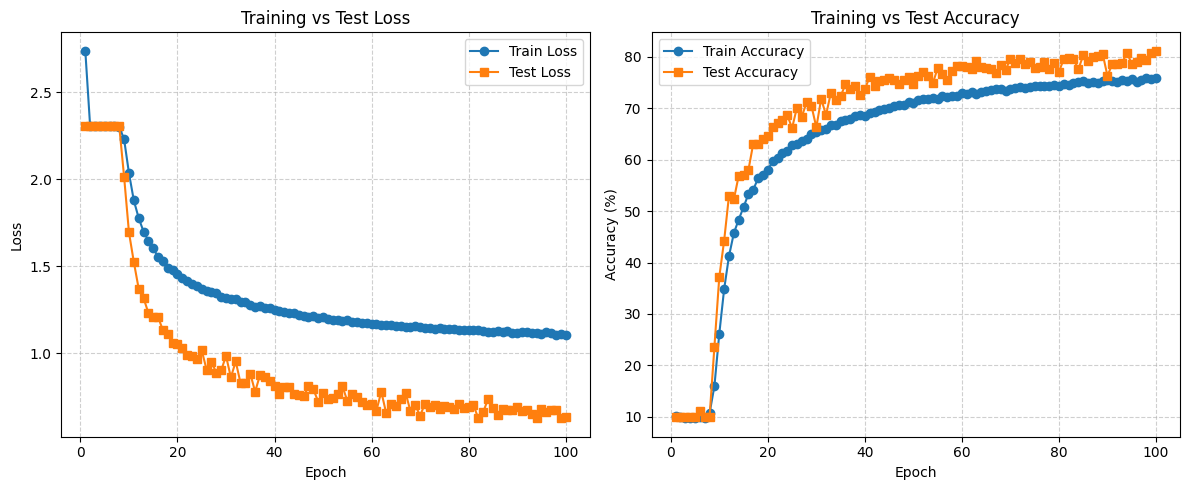

In [7]:
helper.plot_metrics(fp32_metrics)

In [8]:
acc_fp32 = helper.evaluate(model_fp32,test_loader,device)
print(f"FP32 Test Accuracy: {acc_fp32}%")

FP32 Test Accuracy: 81.19%


## Task 2: Squeezenet QAT

For task 2 we perform fixed point QAT on SqueezeNet. Below are two different approaches that we tried to minimize the accuracy loss from quantization. We achieve a final quantized test accuracy of 79.62%.

In [9]:
import torch
class FixedPointQuantizeSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, total_bits=8, int_bits=4, signed=True):
        frac_bits = total_bits - int_bits
        scale = 2 ** frac_bits
        
        if signed:
            max_val = (2 ** (int_bits - 1) - 1)
            min_val = -2 ** (int_bits - 1)
        else:
            max_val = (2 ** int_bits - 1)
            min_val = 0
        
        # quantize
        q_int = torch.clamp(torch.round(input * scale), min_val * scale, max_val * scale)
        q_out = q_int / scale
        return q_out

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, None, None, None

def fixed_point_quantize_weights_ste(weights, total_bits=8, int_bits=4):
    return FixedPointQuantizeSTE.apply(weights, total_bits, int_bits, True)

def fixed_point_quantize_activations_ste(activations, total_bits=8, int_bits=4):
    return FixedPointQuantizeSTE.apply(activations, total_bits, int_bits, False)

In [10]:
class Conv2dQuant(nn.Conv2d):
    def __init__(self, in_features, out_features, k, s = 1, p = 0):
        super(Conv2dQuant, self).__init__(in_features, out_features,kernel_size=k,stride=s,padding=p)
        self.s = s
        self.p = p

    def forward(self, input_):
        w_q = fixed_point_quantize_weights_ste(self.weight)
        return  nn.functional.conv2d(
            input_,
            w_q,
            bias=self.bias,
            stride=self.s,
            padding=self.p,
            dilation=self.dilation,
            groups=self.groups
        )

In [11]:
import torch.nn as nn

class Fire(nn.Module):
    def __init__(self, inplanes, squeeze_planes, expand_planes):
        super(Fire, self).__init__()
        self.conv1 = Conv2dQuant(inplanes, squeeze_planes, k=1)
        self.relu1 = nn.ReLU()
        self.conv2 = Conv2dQuant(squeeze_planes, expand_planes, k=1)
        self.conv3 = Conv2dQuant(squeeze_planes, expand_planes, k=3, p=1)
        self.relu2 = nn.ReLU()

    def forward(self, x, epoch=None, inference=False):
        x = self.conv1(x)
        x = self.relu1(x)
        # print(f"ReLU1 Min value: {x.min().item()}, Max value: {x.max().item()}")
        if inference or (epoch and epoch > 3):
            x = fixed_point_quantize_activations_ste(x)
        
        out1 = self.conv2(x)
        out2 = self.conv3(x)
        out = torch.cat([out1, out2], 1)
        
        out = self.relu2(out)
        # print(f"ReLU2: Min value: {x.min().item()}, Max value: {x.max().item()}")
        if inference or (epoch and epoch > 3):
            out = fixed_point_quantize_activations_ste(out)
            
        return out

class SqueezeNetCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(SqueezeNetCIFAR10, self).__init__()

        # self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3)
        self.conv1 = Conv2dQuant(3, 96, k=7, s=2, p=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire2 = Fire(96, 16, 64)
        self.fire3 = Fire(128, 16, 64)
        self.fire4 = Fire(128, 32, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire5 = Fire(256, 32, 128)
        self.fire6 = Fire(256, 48, 192)
        self.fire7 = Fire(384, 48, 192)
        self.fire8 = Fire(384, 64, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire9 = Fire(512, 64, 256)
        # self.conv10 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.conv10 = Conv2dQuant(512, num_classes, k=1)
        # self.avg_pool = nn.AvgPool2d(13)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x, epoch=None, inference = False):
        x = self.maxpool1(self.conv1(x))
        # print(f"MaxPool1: Min value: {x.min().item()}, Max value: {x.max().item()}")
        if inference or (epoch and epoch > 3):
            x = fixed_point_quantize_activations_ste(x)

        x = self.fire2(x)
        x = self.fire3(x)
        x = self.fire4(x)
        x = self.maxpool2(x)

        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        x = self.maxpool3(x)

        x = self.fire9(x)
        x = self.conv10(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        return x
    
    def load_model(self, path='squeezenet_fp32.pth',device='cpu'):
        state_dict = torch.load(path,map_location=device)

        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[len('module.'):]
            new_state_dict[k] = v

        self.load_state_dict(new_state_dict)
        self.to(device)
        self.eval()

        print(f"Model loaded from {path}")

    def save_model(self, path='squeezenet_fp32.pth'):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")

In [12]:
model_qat = SqueezeNetCIFAR10().to(device)
model_qat.load_model('squeezenet_fp32.pth')

Model loaded from squeezenet_fp32.pth


In [13]:
qat_metrics = helper.train_model(model_qat,
                                 train_loader,
                                 test_loader,
                                 device=device,
                                 epochs=15,
                                 lr=1e-4,
                                 weight_decay=1e-4,
                                 name="squeezenetLR4",
                                 save=True,
                                 acc=acc_fp32)

Epoch [1/15] 

Train Loss: 1.0774, Train Acc: 77.26% 

Test/Val Loss: 0.6107, Test/Val Acc: 81.58%
Epoch [2/15] 

Train Loss: 1.0587, Train Acc: 78.29% 

Test/Val Loss: 0.5972, Test/Val Acc: 81.90%
Epoch [3/15] 

Train Loss: 1.0550, Train Acc: 78.23% 

Test/Val Loss: 0.6050, Test/Val Acc: 81.68%
Epoch [4/15] 

Train Loss: 1.0588, Train Acc: 78.14% 

Test/Val Loss: 0.5760, Test/Val Acc: 82.32%
Epoch [5/15] 

Train Loss: 1.1236, Train Acc: 75.11% 

Model saved to squeezenetLR4_4.pth
Test/Val Loss: 0.6506, Test/Val Acc: 80.13%
Epoch [6/15] 

Train Loss: 1.1050, Train Acc: 75.88% 

Model saved to squeezenetLR4_5.pth
Test/Val Loss: 0.6339, Test/Val Acc: 80.90%
Epoch [7/15] 

Train Loss: 1.1022, Train Acc: 76.04% 

Model saved to squeezenetLR4_6.pth
Test/Val Loss: 0.6433, Test/Val Acc: 80.22%
Epoch [8/15] 

Train Loss: 1.1136, Train Acc: 75.49% 

Model saved to squeezenetLR4_7.pth
Test/Val Loss: 0.6422, Test/Val Acc: 80.61%
Epoch [9/15] 

Train Loss: 1.1123, Train Acc: 75.63% 

Model saved to squeezenetLR4_8.pth
Test/Val Loss: 0.6574, Test/Val Acc: 79.72%
Epoch [10/15] 

Train Loss: 1.1094, Train Acc: 75.54% 

Model saved to squeezenetLR4_9.pth
Test/Val Loss: 0.6422, Test/Val Acc: 79.41%
Epoch [11/15] 

Train Loss: 1.1093, Train Acc: 75.62% 

Model saved to squeezenetLR4_10.pth
Test/Val Loss: 0.6449, Test/Val Acc: 79.81%
Epoch [12/15] 

Train Loss: 1.1104, Train Acc: 75.70% 

Model saved to squeezenetLR4_11.pth
Test/Val Loss: 0.6323, Test/Val Acc: 80.18%
Epoch [13/15] 

Train Loss: 1.1177, Train Acc: 75.04% 

Model saved to squeezenetLR4_12.pth
Test/Val Loss: 0.6418, Test/Val Acc: 80.73%
Epoch [14/15] 

Train Loss: 1.1116, Train Acc: 75.54% 

Model saved to squeezenetLR4_13.pth
Test/Val Loss: 0.6385, Test/Val Acc: 80.03%
Epoch [15/15] 

Train Loss: 1.1147, Train Acc: 75.41% 

Model saved to squeezenetLR4_14.pth
Test/Val Loss: 0.6515, Test/Val Acc: 79.62%


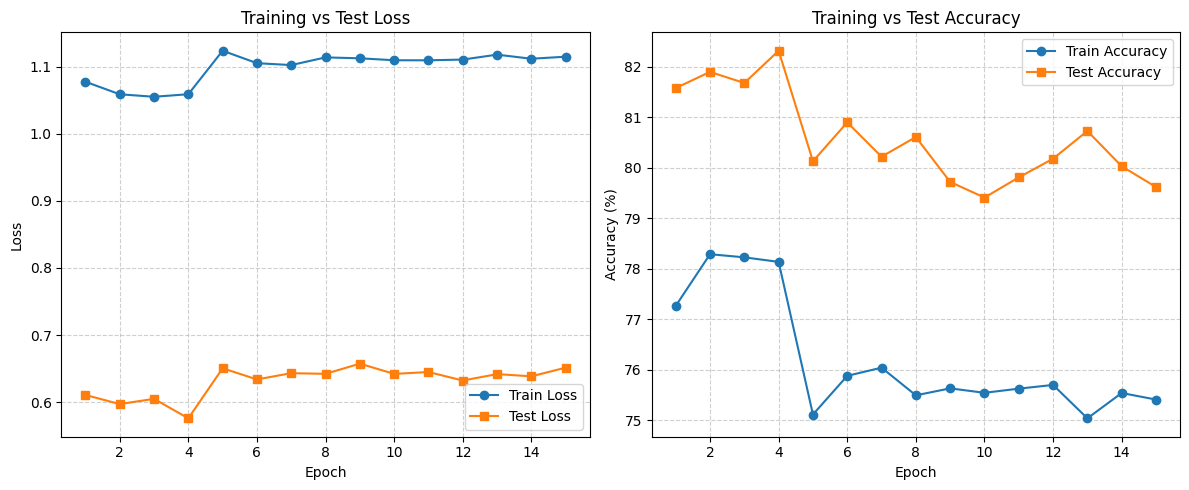

In [14]:
helper.plot_metrics(qat_metrics)

In [15]:
model_qat.save_model('squeezenet_qat.pth')

Model saved to squeezenet_qat.pth


In [16]:
model = SqueezeNetCIFAR10()
model.load_model('squeezenet_qat.pth')
acc = helper.verify_quantized_model(model,test_loader,device)
print(f"Fixed Precision Accuracy: {acc:.2f}")

Model loaded from squeezenet_qat.pth


Fixed Precision Accuracy: 79.62
